In [1]:
%pip install numpy opencv-python lmdb Pillow tqdm PyYAML pygame scipy scikit-image einops seaborn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install apex

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install sconf numpy

Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118
     |███████████████▊                | 413.5 MB 135.1 MB/s eta 0:00:04

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 839.7 MB 8.0 kB/s s eta 0:00:01
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.18.0%2Bcu118-cp39-cp39-linux_x86_64.whl (6.3 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.3.0%2Bcu118-cp39-cp39-linux_x86_64.whl (3.3 MB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cublas_cu11-11.11.3.6-py3-none-manylinux1_x86_64.whl (417.9 MB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_curand_cu11-10.3.0.86-py3-none-manylinux1_x86_64.whl (58.1 MB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cudnn_cu11-8.7.0.84-py3-none-manylinux1_x86_64.whl (728.5 MB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_nvtx_cu11-11.8.86-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cusolver_cu11-11.4.1.48-py3-none-manylinux1_x86_64.whl (128.2 MB)
     |████████████████████████████████| 142.9 MB 118.4 MB/s eta 0:00:01
  Using

In [4]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())

11.8
True


In [5]:
%cd /home/studio-lab-user/VQ-Font

/home/studio-lab-user/VQ-Font


In [6]:
import sys
from pathlib import Path
notebook_dir = Path().resolve().parent
sys.path.append(str(notebook_dir.parent))  # the absolute path to the code
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from six.moves import xrange
import os

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from model import content_enc_builder
from model import dec_builder

from torch.utils.data import Dataset
from PIL import Image, ImageFile
from model.modules import weights_init
import pprint
import json
import tqdm

In [7]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._num_embeddings = num_embeddings
        self._embedding_dim = embedding_dim
        self._commitment_cost = commitment_cost

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1 / self._num_embeddings, 1 / self._num_embeddings)


    def forward(self, inputs):
        # 传入的是图片经过encoder后的feature maps
        # convert inputs from BCHW
        input_shape = inputs.shape

        # Flatten input ->[BC HW]
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input ** 2, dim=1, keepdim=True)
                     + torch.sum(self._embedding.weight ** 2, dim=1)
                     - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) #得到编号
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized, perplexity, encodings

In [8]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input ** 2, dim=1, keepdim=True)
                     + torch.sum(self._embedding.weight ** 2, dim=1)
                     - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                    (self._ema_cluster_size + self._epsilon)
                    / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [9]:
class Model(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()

        self._encoder = content_enc_builder(1,32,256)

        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = dec_builder(32, 1)

    def forward(self, x):
        z = self._encoder(x) #[B 256 16 16]
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity


In [10]:
class CombTrain_VQ_VAE_dataset(Dataset):
    """
    CombTrain_VQ_VAE_dataset, learn the laten codebook from content font. 
    """

    def __init__(self, root, transform = None):
        self.img_path = root
        self.transform = transform
        self.imgs = self.read_file(self.img_path)
        # img = Image.open(self.imgs[0])
        # img = self.transform(img)
        # print(img.shape)


    def read_file(self, path):
        """从文件夹中读取数据"""
        files_list = os.listdir(path)
        file_path_list = [os.path.join(path, img) for img in files_list]
        file_path_list.sort()
        return file_path_list


    def __getitem__(self, index):
        img_name = self.imgs[index]
        #print(img_name[-5:-4])
        img = Image.open(img_name)
        if self.transform is not None:
            img = self.transform(img) #Tensor [C H W] [1 128 128]
        return img

    def __len__(self):

        return len(self.imgs)

In [11]:
from torchvision.utils import make_grid

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_imgs_path = 'data/content/arial_115'
tensorize_transform = transforms.Compose([transforms.Resize((128, 128)),
                                          transforms.ToTensor()])

train_dataset = CombTrain_VQ_VAE_dataset(train_imgs_path, transform=tensorize_transform)

train_loader = DataLoader(train_dataset, batch_size=115, batch_sampler=None, drop_last=True, pin_memory=True, shuffle=True)

num_training_updates = 15000

embedding_dim = 256
num_embeddings = 100

commitment_cost = 0.25

decay = 0

learning_rate = 2e-4

model = Model(num_embeddings, embedding_dim, commitment_cost, decay).to(device)
model.apply(weights_init("xavier"))

optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

model.train()
train_res_recon_error = []
train_res_perplexity = []
train_vq_loss = []


def val(model,validation_loader):
    model.eval()

    valid_originals = next(iter(validation_loader))
    valid_originals = valid_originals.to(device)

    vq_output_eval = model._encoder(valid_originals)
    _, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
    valid_reconstructions = model._decoder(valid_quantize)

def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)


for i in xrange(num_training_updates):
    data = next(iter(train_loader))
    train_data_variance = torch.var(data)
    # print(train_data_variance)
    # show(make_grid(data.cpu().data) )
    # break
    data = data - 0.5 # normalize to [-0.5, 0.5]
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    # data_recon重构图像
    # print("vq_loss\n",vq_loss)
    recon_error = F.mse_loss(data_recon, data) / train_data_variance
    loss = recon_error + vq_loss
    # 重构损失更新encoder以及decoder,vq_loss用来更新embedding空间
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())
    train_vq_loss.append(vq_loss.item())

    if (i + 1) % 1000 == 0:
        print('%d iterations' % (i + 1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-1000:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-1000:]))
        print('vq_loss: %.3f' % np.mean(train_vq_loss[-1000:]))
        print()
        # show(make_grid(data.cpu().data) )

1000 iterations
recon_error: 0.356
perplexity: 15.902
vq_loss: 663.667

2000 iterations
recon_error: 0.269
perplexity: 17.211
vq_loss: 9.531

3000 iterations
recon_error: 0.257
perplexity: 36.981
vq_loss: 0.605

4000 iterations
recon_error: 0.256
perplexity: 67.838
vq_loss: 0.108

5000 iterations
recon_error: 0.277
perplexity: 63.957
vq_loss: 1.672

6000 iterations
recon_error: 0.259
perplexity: 63.240
vq_loss: 0.059

7000 iterations
recon_error: 0.268
perplexity: 53.918
vq_loss: 1.835

8000 iterations
recon_error: 0.259
perplexity: 57.178
vq_loss: 0.674

9000 iterations
recon_error: 0.258
perplexity: 50.371
vq_loss: 0.383

10000 iterations
recon_error: 0.257
perplexity: 37.814
vq_loss: 0.078

11000 iterations
recon_error: 0.257
perplexity: 33.217
vq_loss: 0.016

12000 iterations
recon_error: 0.257
perplexity: 32.843
vq_loss: 0.018

13000 iterations
recon_error: 0.257
perplexity: 26.221
vq_loss: 0.060

14000 iterations
recon_error: 0.257
perplexity: 32.422
vq_loss: 0.093

15000 iterati

## Old version

In [12]:
from torchvision.utils import make_grid
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_imgs_path = 'data/content/arial_115'
tensorize_transform = transforms.Compose([transforms.Resize((128, 128)),
                                          transforms.ToTensor()])

train_dataset = CombTrain_VQ_VAE_dataset(train_imgs_path, transform=tensorize_transform)

train_loader = DataLoader(train_dataset, batch_size=57, batch_sampler=None, drop_last=True, pin_memory=True, shuffle=True)

num_training_updates = 20000

embedding_dim = 128
num_embeddings = 64

commitment_cost = 0.2

decay = 0

learning_rate = 2e-4

model = Model(num_embeddings, embedding_dim, commitment_cost, decay).to(device)
model.apply(weights_init("xavier"))

optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

model.train()
train_res_recon_error = []
train_res_perplexity = []
train_vq_loss = []


def val(model, validation_loader):
    model.eval()

    valid_originals = next(iter(validation_loader))
    valid_originals = valid_originals.to(device)

    vq_output_eval = model._encoder(valid_originals)
    _, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
    valid_reconstructions = model._decoder(valid_quantize)

def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)


for i in range(num_training_updates):
    for data in train_loader:
        train_data_variance = torch.var(data)
        data = data - 0.5  # normalize to [-0.5, 0.5]
        data = data.to(device)
        optimizer.zero_grad()

        vq_loss, data_recon, perplexity = model(data)
        recon_error = F.mse_loss(data_recon, data) / train_data_variance
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()

        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())
        train_vq_loss.append(vq_loss.item())

    if (i + 1) % 1000 == 0:
        print('%d iterations' % (i + 1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-1000:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-1000:]))
        print('vq_loss: %.3f' % np.mean(train_vq_loss[-1000:]))
        print()


In [12]:
val_imgs_path = 'data/content/arial_21'
tensorize_transform = transforms.Compose([transforms.Resize((128, 128)),
                                          transforms.ToTensor()])

val_dataset = CombTrain_VQ_VAE_dataset(val_imgs_path, transform=tensorize_transform)

validation_loader = DataLoader(val_dataset, batch_size=7, batch_sampler=None, drop_last=True, pin_memory=True, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5].


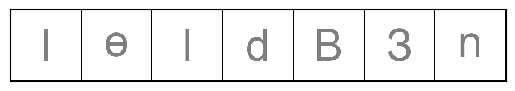

In [13]:
def val_(model,validation_loader):
    model.eval()

    valid_originals = next(iter(validation_loader))
    valid_originals = valid_originals.to(device)

    vq_output_eval = model._encoder(valid_originals)
    _, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
    valid_reconstructions = model._decoder(valid_quantize)
    return valid_originals, valid_reconstructions
    
org, recon_out = val_(model, validation_loader)
show(make_grid((org+0.5).cpu().data), )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0112994].


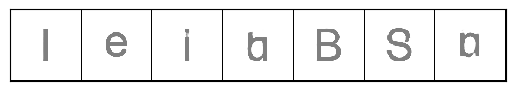

In [14]:
show(make_grid((recon_out+0.5).cpu().data), )

In [15]:
torch.save(model,'weight/VQ-VAE_chn_.pth')    #保存所有的网络参数
torch.save(model.state_dict(),'weight/VQ-VAE_Parms_chn_.pth')

In [16]:
embedding_dim, num_embeddings, commitment_cost, decay = 256, 100, 0.25, 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(num_embeddings, embedding_dim, commitment_cost, decay).to(device)
models = torch.load('weight/VQ-VAE_chn_.pth')
encoder = models._encoder
encoder.requires_gradq = False
encoder.to("cpu")
#定义dataset
class CombTrain_VQ_VAE_dataset(Dataset):
    def __init__(self, root, transform = None):
        self.img_path = root
        self.transform = transform
        self.imgs = self.read_file(self.img_path)
        # img = Image.open(self.imgs[0])
        # img = self.transform(img)
        # print(img.shape)


    def read_file(self, path):
        """从文件夹中读取数据"""
        files_list = os.listdir(path)
        file_path_list = [os.path.join(path, img) for img in files_list]
        file_path_list.sort()
        return file_path_list


    def __getitem__(self, index):
        img_name = self.imgs[index]
        img = Image.open(img_name)
        if self.transform is not None:
            img = self.transform(img) #Tensor [C H W] [1 128 128]
        ret =(img_name, 
              img
        )
        return ret

    def __len__(self):

        return len(self.imgs)




train_imgs_path = 'data/content/arial_136'
tensorize_transform = transforms.Compose([transforms.Resize((128, 128)),
                                          transforms.ToTensor()])

batch = 136 # all content imgs

sim_dataset = CombTrain_VQ_VAE_dataset(train_imgs_path, transform=tensorize_transform)

sim_loader = DataLoader(sim_dataset, batch_size=batch, batch_sampler=None, drop_last=False, pin_memory=True)

similarity = []

def CosineSimilarity(tensor_1, tensor_2):
    normalized_tensor_1 = tensor_1 / tensor_1.norm(dim=-1, keepdim=True)
    normalized_tensor_2 = tensor_2 / tensor_2.norm(dim=-1, keepdim=True)
    return (normalized_tensor_1 * normalized_tensor_2).sum(dim=-1)


while True:
    data = next(iter(sim_loader))
    img_name = data[0]
    img_tensor = data[1]
    img_tensor = img_tensor - 0.5 # normalize to [-0.5, 0.5]
    img_tensor = img_tensor.to("cpu")
    
    #得到了conten的feature
    content_feature = encoder(img_tensor)
    # print(content_feature.shape)
    vector = content_feature.view(content_feature.shape[0], -1)
    # print(vector.shape)
    
    sim_all = {}
    for i in range(0,batch):
        char_i = hex(ord(img_name[i].split('_')[2]))[2:].upper()
        dict_sim_i = {char_i:{}}
        for j in range(0,batch):
            char_j = hex(ord(img_name[j].split('_')[2]))[2:].upper()
            similarity = CosineSimilarity(vector[i],vector[j])
            if i==j:
                similarity=1.0
            sim_i2j = {char_j:float(similarity)}
            dict_sim_i[char_i].update(sim_i2j)
        sim_all.update(dict_sim_i)

        
    dict_json=json.dumps(sim_all)#转化为json格式文件

    #将json文件保存为.json格式文件
    with open('weight/all_char_similarity_unicode.json','w+', encoding='utf-8') as file:
        file.write(dict_json)    
    break

In [17]:
with open('weight/all_char_similarity_unicode.json','r+', encoding='utf-8') as file:
    content=file.read()
    
content=json.loads(content)#将json格式文件转化为python的字典文件
print(content['4C'])

{'61': 0.04263447970151901, '62': 0.536594033241272, '63': 0.0761694461107254, '64': 0.4300118684768677, '65': 0.022931458428502083, '66': 0.09344466030597687, '67': 0.37584951519966125, '68': 0.47559216618537903, '69': 0.14127491414546967, '6A': 0.06462696194648743, '6B': 0.5145952701568604, '6C': 0.12115943431854248, '6D': -0.04853231832385063, '6E': 0.19519658386707306, '6F': 0.034251026809215546, '70': 0.2652084529399872, '71': 0.22408391535282135, '72': 0.0075524188578128815, '73': 0.06608428061008453, '74': 0.17567986249923706, '75': 0.15435707569122314, '76': 0.07093852758407593, '77': -0.03914494067430496, '78': 0.07406730949878693, '79': 0.2677600085735321, '7A': 0.01658780686557293, '430': 0.04263447970151901, '431': 0.3601335287094116, '432': 0.07499417662620544, '433': -0.01811268925666809, '434': 0.12491495907306671, '435': 0.022931458428502083, '436': -0.09508385509252548, '437': 0.025590412318706512, '438': 0.1606648862361908, '439': 0.32673853635787964, '43A': 0.1821450